#Fake News Classification

Fake news is a societal problem with countries having their own regulations to stem out fake news (for instance, my own country Singapore, has a "Protection from Online Falsehoods and Manipulation Act" (POFMA) law to combat fake news). Being able to tell real from fake is supposed to be critical. However, I am skeptical about whether machine learning can really do this reliably. What counts as "ground truth" when truth itself can be messy, biased, or disputed? I'm exploring this problem through a Kaggle project, to not just build a model, but also to explore the dataset/ and outcomes.

[Kaggle competition link ](https://www.kaggle.com/datasets/aadyasingh55/fake-news-classification/data)

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from textblob import TextBlob

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df_train = pd.read_csv(
    '/content/drive/MyDrive/Jiayi_master_5511/archive (2)/train (2).csv',
    sep = ';',
    engine = 'python'
)

df_evaluation = pd.read_csv(
    '/content/drive/MyDrive/Jiayi_master_5511/archive (2)/evaluation.csv',
    sep=';',
    engine='python'
)

In [4]:
df_train.head(5)

,Unnamed: 0,title,text,label
0,0,Palestinians switch off Christmas lights in Be...,"RAMALLAH, West Bank (Reuters) - Palestinians s...",1
1,1,China says Trump call with Taiwan president wo...,BEIJING (Reuters) - U.S. President-elect Donal...,1
2,2,FAIL! The Trump Organization’s Credit Score W...,While the controversy over Trump s personal ta...,0
3,3,Zimbabwe military chief's China trip was norma...,BEIJING (Reuters) - A trip to Beijing last wee...,1
4,4,THE MOST UNCOURAGEOUS PRESIDENT EVER Receives ...,There has never been a more UNCOURAGEOUS perso...,0


In [5]:
df_evaluation.head(5)

,Unnamed: 0,title,text,label
0,0,"Sanders back in U.S. Senate, blasts 'coloniali...",WASHINGTON (Reuters) - Democratic U.S. preside...,1
1,1,Kremlin: Syria peoples' congress being 'active...,MOSCOW (Reuters) - A proposal to convene a con...,1
2,2,Oregon Cop Convicted Of Shattering Biker’s Co...,"In a baffling fit of rage, an Oregon State Pol...",0
3,3,Twitter Erupts With Glee Over #CruzSexScandal...,The last thing any politician running for the ...,0
4,4,MUST WATCH VIDEO: Obama Tries To Trash Trump B...,This is too good to miss! Mr. Teleprompter did...,0


In [6]:
print("\nTrain Data Summary:")
print(df_train.info())

print("\nEvaluation Data Summary:")
print(df_evaluation.info())


Train Data Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24353 entries, 0 to 24352
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  24353 non-null  int64 
 1   title       24353 non-null  object
 2   text        24353 non-null  object
 3   label       24353 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 761.2+ KB
None

Evaluation Data Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8117 entries, 0 to 8116
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  8117 non-null   int64 
 1   title       8117 non-null   object
 2   text        8117 non-null   object
 3   label       8117 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 253.8+ KB
None


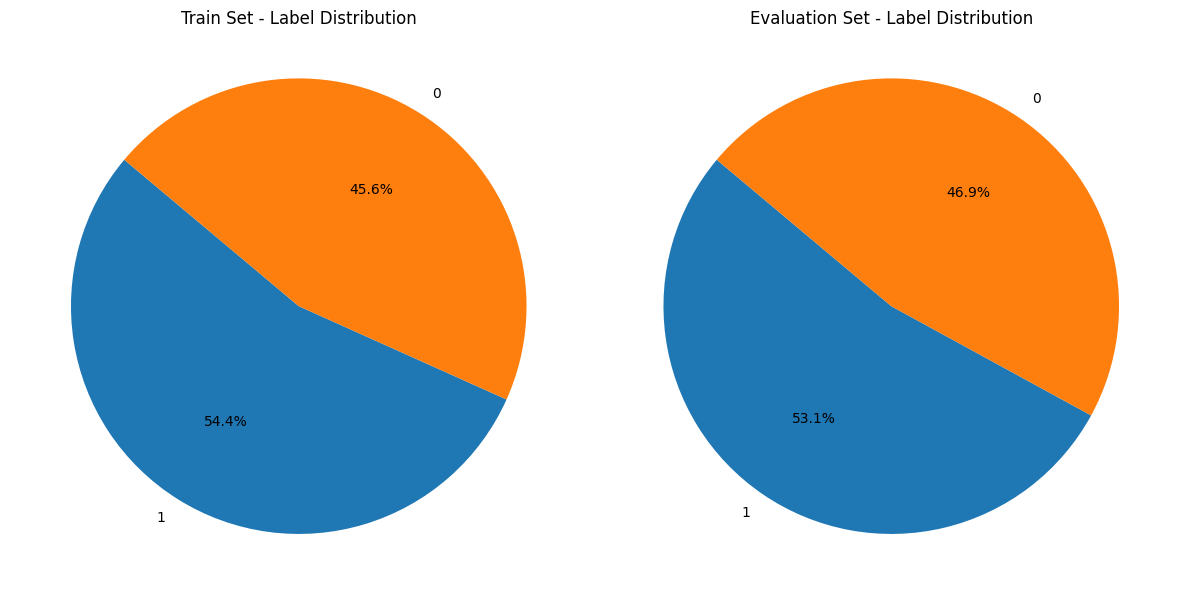

In [7]:
import matplotlib.pyplot as plt

def plot_label_distribution(df1, df2, title1, title2):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    label_counts1 = df1['label'].value_counts()
    axes[0].pie(label_counts1, labels=label_counts1.index, autopct='%1.1f%%', startangle=140)
    axes[0].set_title(f'{title1} - Label Distribution')
    axes[0].axis('equal')

    label_counts2 = df2['label'].value_counts()
    axes[1].pie(label_counts2, labels=label_counts2.index, autopct='%1.1f%%', startangle=140)
    axes[1].set_title(f'{title2} - Label Distribution')
    axes[1].axis('equal')

    plt.tight_layout()
    plt.show()

plot_label_distribution(df_train, df_evaluation, "Train Set", "Evaluation Set")


In [9]:
df_train['sentiment_polarity'] = df_train['text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

df_train['sentiment_label'] = df_train['sentiment_polarity'].apply(
    lambda x: 'positive' if x > 0 else 'negative'
)

In [10]:
df_evaluation.head(5)

,Unnamed: 0,title,text,label
0,0,"Sanders back in U.S. Senate, blasts 'coloniali...",WASHINGTON (Reuters) - Democratic U.S. preside...,1
1,1,Kremlin: Syria peoples' congress being 'active...,MOSCOW (Reuters) - A proposal to convene a con...,1
2,2,Oregon Cop Convicted Of Shattering Biker’s Co...,"In a baffling fit of rage, an Oregon State Pol...",0
3,3,Twitter Erupts With Glee Over #CruzSexScandal...,The last thing any politician running for the ...,0
4,4,MUST WATCH VIDEO: Obama Tries To Trash Trump B...,This is too good to miss! Mr. Teleprompter did...,0


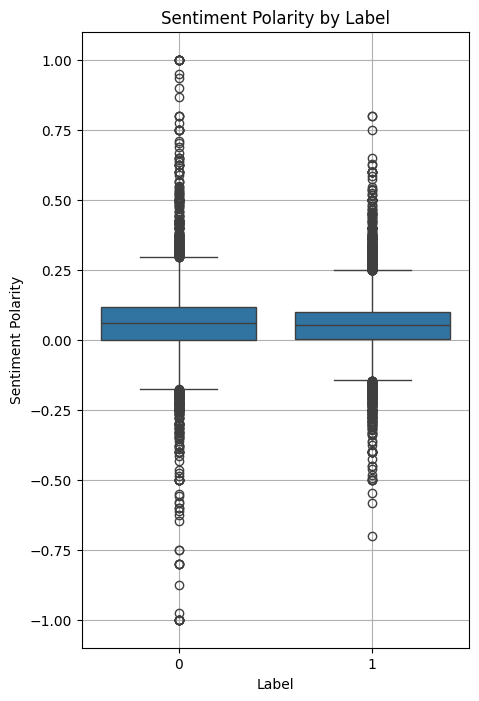

In [11]:
plt.figure(figsize=(5, 8))
sns.boxplot(data=df_train, x='label', y='sentiment_polarity')
plt.title('Sentiment Polarity by Label')
plt.xlabel('Label')
plt.ylabel('Sentiment Polarity')
plt.grid(True)
plt.show()

The boxplot comparing sentiment polarity across real and fake news articles shows that both categories have very similar distributions. The median polarity, spread, and presence of outliers are nearly identical between the two groups. This suggests that sentiment does not clearly distinguish between real and fake news. Both types of articles can express positive, negative, or neutral sentiment, so sentiment polarity alone is unlikely to be a reliable feature for classification in this context.

Since I have the labels and for the purpose of this assignment, let's work on a BiLSTM model to differentiate. Previously I worked with a BiLSTM model on week 4 as well, but I'm not sure whether it can perform well here.

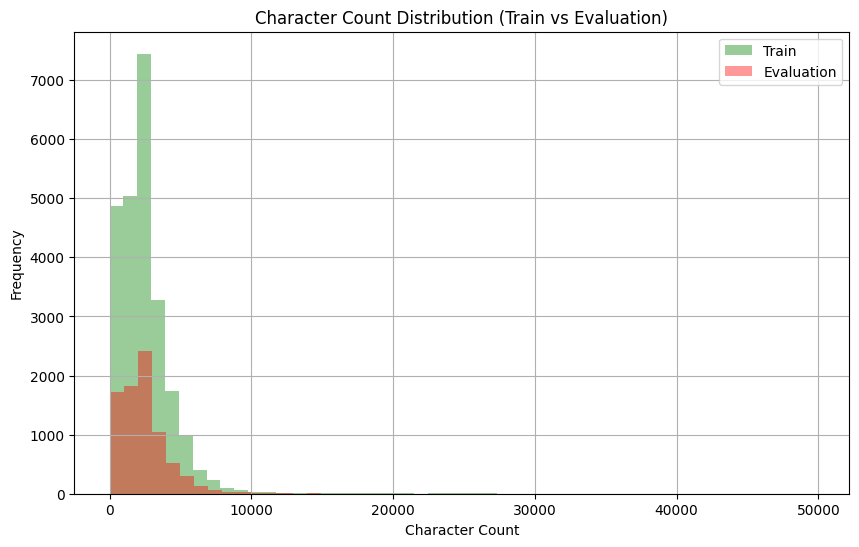

In [12]:
df_train['char_count'] = df_train['text'].astype(str).apply(len)
df_evaluation['char_count'] = df_evaluation['text'].astype(str).apply(len)


plt.figure(figsize=(10, 6))
plt.hist(df_train['char_count'], bins=50, color='green', alpha=0.4, label='Train')
plt.hist(df_evaluation['char_count'], bins=50, color='red', alpha=0.4, label='Evaluation')
plt.title('Character Count Distribution (Train vs Evaluation)')
plt.xlabel('Character Count')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

I think I can justifiably truncate at around 6000 characters ~ 1500 tokens, given that the 95th percentile is only about 5600 characters.

In [15]:
char_count_95 = df_train['char_count'].quantile(0.95)
print(f"95th percentile character count: {char_count_95}")

95th percentile character count: 5557.399999999998


In [16]:
max_vocab = 20000
max_len = 1500

tokenizer = Tokenizer(num_words=max_vocab, oov_token='<OOV>')
tokenizer.fit_on_texts(df_train['text'])

X_train = tokenizer.texts_to_sequences(df_train['text'])
X_train = pad_sequences(X_train, maxlen=max_len, padding='post', truncating='post')

X_eval = tokenizer.texts_to_sequences(df_evaluation['text'])
X_eval = pad_sequences(X_eval, maxlen=max_len, padding='post', truncating='post')

y_train = df_train['label'].astype(int).values
y_eval = df_evaluation['label'].astype(int).values

In [17]:
embedding_dim = 50

model = Sequential([
    Embedding(input_dim=max_vocab, output_dim=embedding_dim, input_length=max_len),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [18]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(
    X_train, y_train,
    validation_data=(X_eval, y_eval),
    epochs=10,
    batch_size=32
)

Epoch 1/10
762/762 ━━━━━━━━━━━━━━━━━━━━ 80s 97ms/step - accuracy: 0.8988 - loss: 0.2304 - val_accuracy: 0.9841 - val_loss: 0.0479
Epoch 2/10
762/762 ━━━━━━━━━━━━━━━━━━━━ 73s 96ms/step - accuracy: 0.9912 - loss: 0.0306 - val_accuracy: 0.9826 - val_loss: 0.0495
Epoch 3/10
762/762 ━━━━━━━━━━━━━━━━━━━━ 73s 96ms/step - accuracy: 0.9968 - loss: 0.0113 - val_accuracy: 0.9826 - val_loss: 0.0710
Epoch 4/10
762/762 ━━━━━━━━━━━━━━━━━━━━ 73s 96ms/step - accuracy: 0.9984 - loss: 0.0071 - val_accuracy: 0.9826 - val_loss: 0.0757
Epoch 5/10
762/762 ━━━━━━━━━━━━━━━━━━━━ 73s 96ms/step - accuracy: 0.9984 - loss: 0.0062 - val_accuracy: 0.9848 - val_loss: 0.0806
Epoch 6/10
762/762 ━━━━━━━━━━━━━━━━━━━━ 73s 96ms/step - accuracy: 0.9998 - loss: 9.2158e-04 - val_accuracy: 0.9834 - val_loss: 0.1098
Epoch 7/10
762/762 ━━━━━━━━━━━━━━━━━━━━ 73s 96ms/step - accuracy: 0.9997 - loss: 0.0013 - val_accuracy: 0.9830 - val_loss: 0.1051
Epoch 8/10
762/762 ━━━━━━━━━━━━━━━━━━━━ 74s 96ms/step - accuracy: 0.9988 - loss: 0.005

In [22]:
model.save('/content/drive/MyDrive/Jiayi_master_5511/archive (2)/bilstm_fake_news_model_v1.keras')

The model above looks like it's overfitting quite quickly. Let's attempt to drop some nodes in the dense layer from 64 > 32 and try again. This time I will also plot the train accuracy and validation accuracy.

In [23]:
model2 = Sequential([
    Embedding(input_dim=max_vocab, output_dim=embedding_dim, input_length=max_len),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [24]:
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history2 = model2.fit(
    X_train, y_train,
    validation_data=(X_eval, y_eval),
    epochs=10,
    batch_size=32
)

Epoch 1/10
762/762 ━━━━━━━━━━━━━━━━━━━━ 77s 97ms/step - accuracy: 0.8985 - loss: 0.2197 - val_accuracy: 0.9835 - val_loss: 0.0497
Epoch 2/10
762/762 ━━━━━━━━━━━━━━━━━━━━ 73s 96ms/step - accuracy: 0.9898 - loss: 0.0366 - val_accuracy: 0.9851 - val_loss: 0.0525
Epoch 3/10
762/762 ━━━━━━━━━━━━━━━━━━━━ 73s 96ms/step - accuracy: 0.9943 - loss: 0.0185 - val_accuracy: 0.9813 - val_loss: 0.0626
Epoch 4/10
762/762 ━━━━━━━━━━━━━━━━━━━━ 73s 96ms/step - accuracy: 0.9984 - loss: 0.0070 - val_accuracy: 0.9819 - val_loss: 0.0775
Epoch 5/10
762/762 ━━━━━━━━━━━━━━━━━━━━ 73s 96ms/step - accuracy: 0.9984 - loss: 0.0065 - val_accuracy: 0.9845 - val_loss: 0.0882
Epoch 6/10
762/762 ━━━━━━━━━━━━━━━━━━━━ 73s 96ms/step - accuracy: 0.9987 - loss: 0.0042 - val_accuracy: 0.9821 - val_loss: 0.0938
Epoch 7/10
762/762 ━━━━━━━━━━━━━━━━━━━━ 73s 96ms/step - accuracy: 0.9996 - loss: 0.0018 - val_accuracy: 0.9839 - val_loss: 0.1124
Epoch 8/10
762/762 ━━━━━━━━━━━━━━━━━━━━ 73s 96ms/step - accuracy: 0.9997 - loss: 0.0012 - 

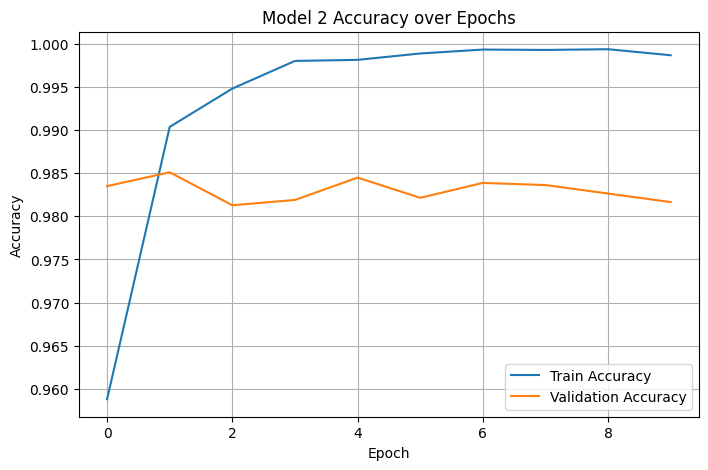

In [25]:
plt.figure(figsize=(8, 5))
plt.plot(history2.history['accuracy'], label='Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model 2 Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [26]:
model2.save('/content/drive/MyDrive/Jiayi_master_5511/archive (2)/bilstm_fake_news_model_v2.keras')

Finally, let's use glove (pretrained) embedding to see whether we can achieve better results.

In [27]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2025-04-29 17:55:53--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-04-29 17:55:53--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-04-29 17:55:54--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [30]:
embedding_index = {}
with open('glove.6B.50d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

print(f"Loaded {len(embedding_index)} word vectors from GloVe.")

Loaded 400000 word vectors from GloVe.


In [31]:
embedding_dim = 50
embedding_matrix = np.zeros((max_vocab, embedding_dim))

for word, index in tokenizer.word_index.items():
    if index < max_vocab:
        vector = embedding_index.get(word)
        if vector is not None:
            embedding_matrix[index] = vector

In [32]:
model3 = Sequential([
    Embedding(
        input_dim=max_vocab,
        output_dim=embedding_dim,
        input_length=max_len,
        weights=[embedding_matrix],
        trainable=False  # freeze GloVe weights
    ),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [34]:
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True)
checkpoint = ModelCheckpoint('/content/drive/MyDrive/Jiayi_master_5511/archive (2)/bilstm_fake_news_model_v3.keras', monitor='val_loss', save_best_only=True)

history3 = model3.fit(
    X_train, y_train,
    validation_data=(X_eval, y_eval),
    epochs=10,
    batch_size=32,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/10
762/762 ━━━━━━━━━━━━━━━━━━━━ 76s 96ms/step - accuracy: 0.9800 - loss: 0.0797 - val_accuracy: 0.9799 - val_loss: 0.0658
Epoch 2/10
762/762 ━━━━━━━━━━━━━━━━━━━━ 74s 97ms/step - accuracy: 0.9802 - loss: 0.0712 - val_accuracy: 0.9809 - val_loss: 0.0577
Epoch 3/10
762/762 ━━━━━━━━━━━━━━━━━━━━ 75s 98ms/step - accuracy: 0.9827 - loss: 0.0723 - val_accuracy: 0.9812 - val_loss: 0.0611
Epoch 4/10
762/762 ━━━━━━━━━━━━━━━━━━━━ 74s 97ms/step - accuracy: 0.9842 - loss: 0.0533 - val_accuracy: 0.9835 - val_loss: 0.0472
Epoch 5/10
762/762 ━━━━━━━━━━━━━━━━━━━━ 74s 97ms/step - accuracy: 0.9856 - loss: 0.0463 - val_accuracy: 0.9850 - val_loss: 0.0447
Epoch 6/10
762/762 ━━━━━━━━━━━━━━━━━━━━ 74s 97ms/step - accuracy: 0.9859 - loss: 0.0403 - val_accuracy: 0.9857 - val_loss: 0.0451
Epoch 7/10
762/762 ━━━━━━━━━━━━━━━━━━━━ 74s 97ms/step - accuracy: 0.9874 - loss: 0.0342 - val_accuracy: 0.9867 - val_loss: 0.0396
Epoch 8/10
762/762 ━━━━━━━━━━━━━━━━━━━━ 74s 97ms/step - accuracy: 0.9887 - loss: 0.0336 - 

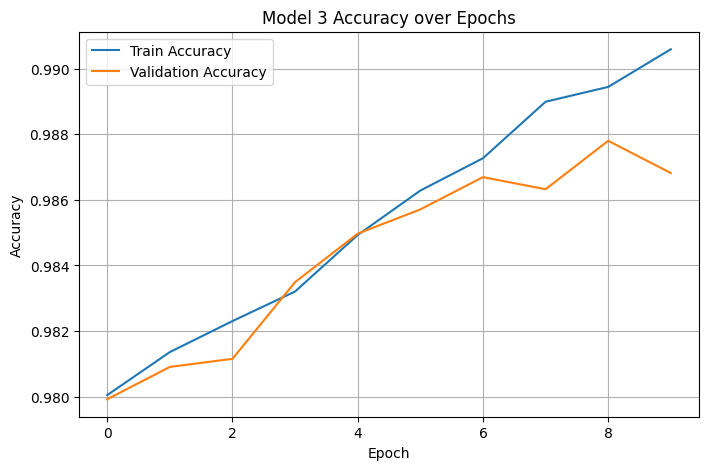

In [35]:
plt.figure(figsize=(8, 5))
plt.plot(history3.history['accuracy'], label='Train Accuracy')
plt.plot(history3.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model 3 Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Now that I have trained the models, I will test the models on the test dataset. I will need to process the test.csv file in the same way that I did for the trainining and evaluation datasets.

In [36]:
df_test = pd.read_csv('/content/drive/MyDrive/Jiayi_master_5511/archive (2)/test (1).csv', sep=';', engine='python')
df_test.rename(columns={df_test.columns[0]: 'id'}, inplace=True)

X_test = tokenizer.texts_to_sequences(df_test['text'])
X_test = pad_sequences(X_test, maxlen=max_len, padding='post', truncating='post')


In [37]:
y_pred_prob = model3.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)
y_true = df_test['label'].astype(int).values

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

254/254 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step
Confusion Matrix:
[[3718   35]
 [  64 4300]]


In [38]:
print("\nClassification Report:")
print(classification_report(y_true, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3753
           1       0.99      0.99      0.99      4364

    accuracy                           0.99      8117
   macro avg       0.99      0.99      0.99      8117
weighted avg       0.99      0.99      0.99      8117



In [39]:
accuracy = accuracy_score(y_true, y_pred)
print(f"\nTotal Accuracy: {accuracy * 100:.2f}%")


Total Accuracy: 98.78%


While I still have some doubts on how we can reliably differentiate fake news from real ones, for this assignment, my deep learning model did attain a pretty accurate score on the test set.

~ End